# Training a CNN model on CIFAR10

### Install dependencies

In [1]:
%pip install matplotlib seaborn torch torchvision torchaudio numpy

Note: you may need to restart the kernel to use updated packages.


#### Prepare imports

In [2]:
import matplotlib.pyplot as plt # This is to load plotting functions
import seaborn as sns; sns.set() # This is to make the plots prettier
import torch # This is the ML library we will use
import torchvision # This is the supporting ML library for computer vision
from torchvision import datasets # This is to access the CIFAR10 dataset
from torch.utils.data import DataLoader # This is used to load the data efficiently
import torchvision.transforms as transforms # This is used to transform data when preparing the dataset
import numpy as np # This is used to handle arrays of data

#### Select the device from GPU and CPU

In [3]:
# If GPU is available, it is chosen for computations, and if not, CPU will be used
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### Download the CIFAR10 dataset and create train and test data loaders

In [4]:
# This is used to normalize input images
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

train_set = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


#### Show example images from the dataset.

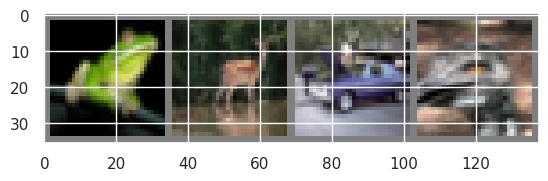

frog  deer  car   bird 


In [5]:

def imshow(img):
    # Unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#### Create a simple CNN classifier model

In [6]:
class Cifar10Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.body = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=6,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(
                in_channels=6,
                out_channels=16,
                kernel_size=5,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(16 * 6 * 6, 120),
            torch.nn.ReLU(),
            torch.nn.Linear(120, 84),
            torch.nn.ReLU(),
            torch.nn.Linear(84, 10),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        output = self.body(x)
        return output

In [7]:
model = Cifar10Classifier()
model.to(device)

Cifar10Classifier(
  (body): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=576, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
    (12): ReLU()
  )
)

#### Create a loss function and an optimizer.

In [8]:
learning_rate = 0.001

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train the model.

In [9]:
def train(num_epochs, model, loss_func, optimizer):

    model.train()

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        # For each batch in the training data
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)

            # Compute output and loss
            output = model(images)
            loss = loss_func(output, labels)

            # Clear gradients for this training step
            optimizer.zero_grad()

            # Compute gradients
            loss.backward()
            # Apply gradients
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch + 1, num_epochs, i + 1, total_step, loss.item()
                    )
                )

    print("Done.")


train(2, model, loss_func, optimizer)

/home/io/miniconda3/envs/diip/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/io/miniconda3/envs/diip/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/2], Step [100/12500], Loss: 2.3026
Epoch [1/2], Step [200/12500], Loss: 2.3026
Epoch [1/2], Step [300/12500], Loss: 2.3026
Epoch [1/2], Step [400/12500], Loss: 2.3026
Epoch [1/2], Step [500/12500], Loss: 2.3026
Epoch [1/2], Step [600/12500], Loss: 2.3026
Epoch [1/2], Step [700/12500], Loss: 2.3026
Epoch [1/2], Step [800/12500], Loss: 2.3026
Epoch [1/2], Step [900/12500], Loss: 2.3026
Epoch [1/2], Step [1000/12500], Loss: 2.3026
Epoch [1/2], Step [1100/12500], Loss: 2.3026
Epoch [1/2], Step [1200/12500], Loss: 2.3026
Epoch [1/2], Step [1300/12500], Loss: 2.3026
Epoch [1/2], Step [1400/12500], Loss: 2.3026
Epoch [1/2], Step [1500/12500], Loss: 2.3026
Epoch [1/2], Step [1600/12500], Loss: 2.3026
Epoch [1/2], Step [1700/12500], Loss: 2.3026
Epoch [1/2], Step [1800/12500], Loss: 2.3026
Epoch [1/2], Step [1900/12500], Loss: 2.3026
Epoch [1/2], Step [2000/12500], Loss: 2.3026
Epoch [1/2], Step [2100/12500], Loss: 2.3026
Epoch [1/2], Step [2200/12500], Loss: 2.3026
Epoch [1/2], Step [

Now, test the trained model.

In [10]:
def test(model):
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)

            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)
        
        accuracy = correct / float(total)
        print('Test Accuracy of the model: %.2f%%' % (accuracy * 100))
test(model)

Test Accuracy of the model: 10.00%


#### Now, let us train more and see how the result changes.

In [11]:
train(1, model, loss_func, optimizer)

Epoch [1/1], Step [100/12500], Loss: 2.3026
Epoch [1/1], Step [200/12500], Loss: 2.3026
Epoch [1/1], Step [300/12500], Loss: 2.3026
Epoch [1/1], Step [400/12500], Loss: 2.3026
Epoch [1/1], Step [500/12500], Loss: 2.3026
Epoch [1/1], Step [600/12500], Loss: 2.3026
Epoch [1/1], Step [700/12500], Loss: 2.3026
Epoch [1/1], Step [800/12500], Loss: 2.3026
Epoch [1/1], Step [900/12500], Loss: 2.3026
Epoch [1/1], Step [1000/12500], Loss: 2.3026
Epoch [1/1], Step [1100/12500], Loss: 2.3026
Epoch [1/1], Step [1200/12500], Loss: 2.3026
Epoch [1/1], Step [1300/12500], Loss: 2.3026
Epoch [1/1], Step [1400/12500], Loss: 2.3026
Epoch [1/1], Step [1500/12500], Loss: 2.3026
Epoch [1/1], Step [1600/12500], Loss: 2.3026
Epoch [1/1], Step [1700/12500], Loss: 2.3026
Epoch [1/1], Step [1800/12500], Loss: 2.3026
Epoch [1/1], Step [1900/12500], Loss: 2.3026
Epoch [1/1], Step [2000/12500], Loss: 2.3026
Epoch [1/1], Step [2100/12500], Loss: 2.3026
Epoch [1/1], Step [2200/12500], Loss: 2.3026
Epoch [1/1], Step [

In [13]:
test(model)

Test Accuracy of the model: 10.00%


## Pretrained ResNet18 model on CIFAR100

#### Load the pretrained model from torchhub.

In [14]:
resnet20_cifar100 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=True)
resnet20_cifar100

Using cache found in /home/io/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

#### CIFAR100 has different number of classes, but input images are compatible in shape.

We can adapt this model by changing the last layer to fit our needs.
The last layer is untrained, but we can freeze the network and train only it, since the earlier model layers are capable of processing visual information from CIFAR100.

The last fully-connected layer should receive as input a vector with the same number of features as before, but the number of output dimensions should be equal to the number of classes in CIFAR10.

<details>
<summary>Solution</summary>
    <code>
    num_features = resnet18.fc.in_features<br>
    resnet20_cifar100.fc = torch.nn.Linear(num_features, num_classes)<br>
    </code>
</details>

In [15]:
num_classes = 10
num_features = resnet20_cifar100.fc.in_features
resnet20_cifar100.fc = torch.nn.Linear(num_features, num_classes)
resnet20_cifar100.to(device)

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

#### Freeze all layers except last.

In [16]:
for param in resnet20_cifar100.parameters():
    param.requires_grad = False

resnet20_cifar100.fc.weight.requires_grad = True
resnet20_cifar100.fc.bias.requires_grad = True

resnet20_cifar100.conv1.weight.requires_grad, resnet20_cifar100.fc.weight.requires_grad

(False, True)

In [17]:
test(resnet20_cifar100)

Test Accuracy of the model: 8.61%


#### Prepare the training objects.

In [18]:
learning_rate = 0.001

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet20_cifar100.parameters(), lr=learning_rate)

#### Train and test (only the last layer is trained).

In [19]:
train(2, resnet20_cifar100, loss_func, optimizer)

Epoch [1/2], Step [100/12500], Loss: 2.4560
Epoch [1/2], Step [200/12500], Loss: 1.8224
Epoch [1/2], Step [300/12500], Loss: 1.8141
Epoch [1/2], Step [400/12500], Loss: 2.1924
Epoch [1/2], Step [500/12500], Loss: 2.3591
Epoch [1/2], Step [600/12500], Loss: 1.7922
Epoch [1/2], Step [700/12500], Loss: 2.0056
Epoch [1/2], Step [800/12500], Loss: 1.3924
Epoch [1/2], Step [900/12500], Loss: 1.1074
Epoch [1/2], Step [1000/12500], Loss: 1.7147
Epoch [1/2], Step [1100/12500], Loss: 1.4108
Epoch [1/2], Step [1200/12500], Loss: 2.2930
Epoch [1/2], Step [1300/12500], Loss: 2.3694
Epoch [1/2], Step [1400/12500], Loss: 2.5404
Epoch [1/2], Step [1500/12500], Loss: 1.6672
Epoch [1/2], Step [1600/12500], Loss: 1.8191
Epoch [1/2], Step [1700/12500], Loss: 1.7181
Epoch [1/2], Step [1800/12500], Loss: 1.7697
Epoch [1/2], Step [1900/12500], Loss: 1.5407
Epoch [1/2], Step [2000/12500], Loss: 2.9034
Epoch [1/2], Step [2100/12500], Loss: 0.7634
Epoch [1/2], Step [2200/12500], Loss: 1.1981
Epoch [1/2], Step [

In [20]:
test(resnet20_cifar100)

Test Accuracy of the model: 62.94%


## Pretrained ResNet18 model on ImageNet

#### Load the pretrained model from torchvision.

In [21]:
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### ImageNet has different image size and the number of classes.

We can adapt this model by changing the first and the last layers to fit our needs.
Those layers are untrained, but the knowledge from all other layers is still relevant and helps the model to be trained faster.

The first convolutional layer of ResNet needs to receive as input an image with 3 channels, have 64 output channels, 3x3 filter, stride 1 and padding 1 with no bias.

The last fully-connected layer should receive as input a vector with the same number of features as before, but the number of output dimensions should be equal to the number of classes in CIFAR10.

<details>
<summary>Solution</summary>
    <code>
    resnet18.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)<br>
    num_features = resnet18.fc.in_features<br>
    resnet18.fc = torch.nn.Linear(num_features, num_classes)<br>
    </code>
</details>

In [22]:
num_classes = 10
resnet18.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
num_features = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_features, num_classes)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### It is pretrained on ImageNet, so the starting accuracy on CIFAR10 should be bad, let us check it.

In [23]:
test(resnet18)

Test Accuracy of the model: 9.90%


#### Prepare the training objects.

In [24]:
learning_rate = 0.001

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)

#### Train and test.

In [25]:
train(2, resnet18, loss_func, optimizer)

Epoch [1/2], Step [100/12500], Loss: 2.7609
Epoch [1/2], Step [200/12500], Loss: 2.4524
Epoch [1/2], Step [300/12500], Loss: 2.2776
Epoch [1/2], Step [400/12500], Loss: 2.3939
Epoch [1/2], Step [500/12500], Loss: 1.8081
Epoch [1/2], Step [600/12500], Loss: 2.1802
Epoch [1/2], Step [700/12500], Loss: 3.1815
Epoch [1/2], Step [800/12500], Loss: 2.0593
Epoch [1/2], Step [900/12500], Loss: 2.2240
Epoch [1/2], Step [1000/12500], Loss: 2.4946
Epoch [1/2], Step [1100/12500], Loss: 2.3982
Epoch [1/2], Step [1200/12500], Loss: 2.1547
Epoch [1/2], Step [1300/12500], Loss: 1.6972
Epoch [1/2], Step [1400/12500], Loss: 1.7882
Epoch [1/2], Step [1500/12500], Loss: 2.2530
Epoch [1/2], Step [1600/12500], Loss: 2.1752
Epoch [1/2], Step [1700/12500], Loss: 1.4363
Epoch [1/2], Step [1800/12500], Loss: 1.4488
Epoch [1/2], Step [1900/12500], Loss: 2.8319
Epoch [1/2], Step [2000/12500], Loss: 1.8800
Epoch [1/2], Step [2100/12500], Loss: 2.0016
Epoch [1/2], Step [2200/12500], Loss: 2.1406
Epoch [1/2], Step [

In [26]:
test(resnet18)

Test Accuracy of the model: 70.02%
